# 청경채 성장 예측 AI 경진 대회
- 환경 데이터로부터 청경채의 일별 잎면적 증감률 예측하는 AI 알고리즘 개발
- 각 청경채 케이스의 생육 기간동안 1분 간격으로 수집된 환경 데이터로부터 일별 잎면적 증감률을 예측
- 평가 산식 : 100*RMSE 

# 라이브러리 임포트 및 파일 불러오기

In [125]:
pip install koreanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import koreanize_matplotlib

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
train_case = glob.glob('drive/MyDrive/mini_DNN/open/train_input/*.csv')
train_case.sort()
train_case[:5]

['drive/MyDrive/mini_DNN/open/train_input/CASE_01.csv',
 'drive/MyDrive/mini_DNN/open/train_input/CASE_02.csv',
 'drive/MyDrive/mini_DNN/open/train_input/CASE_03.csv',
 'drive/MyDrive/mini_DNN/open/train_input/CASE_04.csv',
 'drive/MyDrive/mini_DNN/open/train_input/CASE_05.csv']

In [129]:
train_target = glob.glob('drive/MyDrive/mini_DNN/open/train_target/*.csv')
train_target.sort()
train_target[:5]

['drive/MyDrive/mini_DNN/open/train_target/CASE_01.csv',
 'drive/MyDrive/mini_DNN/open/train_target/CASE_02.csv',
 'drive/MyDrive/mini_DNN/open/train_target/CASE_03.csv',
 'drive/MyDrive/mini_DNN/open/train_target/CASE_04.csv',
 'drive/MyDrive/mini_DNN/open/train_target/CASE_05.csv']

In [130]:
test_case = glob.glob('drive/MyDrive/mini_DNN/open/test_input/*.csv')
test_case.sort()
test_case[:5]

['drive/MyDrive/mini_DNN/open/test_input/TEST_01.csv',
 'drive/MyDrive/mini_DNN/open/test_input/TEST_02.csv',
 'drive/MyDrive/mini_DNN/open/test_input/TEST_03.csv',
 'drive/MyDrive/mini_DNN/open/test_input/TEST_04.csv',
 'drive/MyDrive/mini_DNN/open/test_input/TEST_05.csv']

In [131]:
test_target = glob.glob('drive/MyDrive/mini_DNN/open/test_target/*.csv')
test_target.sort()
test_target[:5]

['drive/MyDrive/mini_DNN/open/test_target/TEST_01.csv',
 'drive/MyDrive/mini_DNN/open/test_target/TEST_02.csv',
 'drive/MyDrive/mini_DNN/open/test_target/TEST_03.csv',
 'drive/MyDrive/mini_DNN/open/test_target/TEST_04.csv',
 'drive/MyDrive/mini_DNN/open/test_target/TEST_05.csv']

In [132]:
# submissions = glob.glob('drive/MyDrive/mini_DNN/open/sample_submission/*.csv')
# submissions.sort()
# submissions[:5]

# 데이터 확인

## Dataset Info.

- train_input- 총 58개 청경채 케이스
    - 각 청경채 케이스 별 환경 데이터 (1분 간격)
- train_target - 총 58개 청경채 케이스
    - rate : 각 청경채 케이스 별 잎 면적 증감률 (1일 간격)
- test_input - 총 6개 청경채 케이스
    - 각 청경채 케이스 별 환경 데이터 (1분 간격)
- test_target - 총 6개 청경채 케이스
    - rate : 각 청경채 케이스 별 잎 면적 증감률 (1일 간격)
제출을 위한 양식으로 label에 해당되는 rate의 값은 모두 0으로 가려져있습니다.

In [133]:
pd.options.display.max_columns = None

In [134]:
pd.read_csv(train_case[0]).head()

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-02-17 00:00:00,24.799999,40.500000,361.0,0.059069,20.299999,33.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,394.0,100.0,201.0,370.0,10.0,201.0,372.0,25.0,0.0,25.0,23.0,24.0,4.5,0.0,0.0,363.554,16.548,37.596000,363.554,309.41,16.548,37.596
1,2021-02-17 00:01:00,20.500000,44.099998,355.0,0.910134,19.700001,10.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,62.0,0.0,201.0,64.0,0.0,201.0,66.0,0.0,0.0,20.0,18.0,19.000,0.000,2.500000,0.000,0.00,0.000,0.000
2,2021-02-17 00:02:00,20.600000,44.299999,360.0,0.910134,19.799999,10.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,179.0,0.0,201.0,182.0,0.0,201.0,184.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000
3,2021-02-17 00:03:00,20.600000,44.500000,359.0,0.908579,19.799999,10.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,117.0,0.0,201.0,120.0,0.0,201.0,122.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000
4,2021-02-17 00:04:00,20.600000,44.500000,357.0,0.910134,19.799999,10.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,57.0,0.0,201.0,60.0,0.0,201.0,62.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000


In [135]:
pd.read_csv(train_target[0]).head()

,시간,rate
0,2021-02-18 00:00:00,0.50000
1,2021-02-19 00:00:00,0.66667
2,2021-02-20 00:00:00,0.60000
3,2021-02-21 00:00:00,-0.12500
4,2021-02-22 00:00:00,1.42857


# CASE 모두 합쳐주기!
-	총 58개의 데이터 파일로 이루어진 train data를 하나의 파일로 합쳐준다.
- feature 이름에 차이가 있어 그걸 해결하면서 합쳐준다.
- x,y dataframe 을 만든다.


## 컬럼 명 확인

In [136]:
column_names = []
for i in train_case:
    column_names.append(set(pd.read_csv(i).columns))

In [137]:
# 개수부터 파악 -> 전부 38개
col_len = []
for i in column_names:
    col_len.append(len(i))
print(set(col_len))

{38}


In [138]:
# 서로 다른 컬럼 및 나오는 횟수 파악
whole_col = []
for i in column_names:
    for j in i:
        whole_col.append(j)

col_cnt = []
for i in set(whole_col):
    col_cnt.append((i,whole_col.count(i)))

col_cnt

[('난방상태', 58),
 ('블루 LED상태', 58),
 ('외부온도추정관측치', 25),
 ('EC관측치', 58),
 ('최근분무량', 45),
 ('적색광추정광량', 58),
 ('청색광추정광량', 58),
 ('카메라상태', 58),
 ('블루 LED작동남은시간', 58),
 ('내부유동팬작동남은시간', 58),
 ('외부환기팬상태', 58),
 ('화이트 LED작동남은시간', 58),
 ('총추정광량', 58),
 ('화이트 LED상태', 58),
 ('외부환기팬작동남은시간', 58),
 ('일간누적분무량', 43),
 ('난방작동남은시간', 58),
 ('레드 LED작동남은시간', 58),
 ('냉방상태', 58),
 ('CO2관측치', 58),
 ('레드 LED동작강도', 58),
 ('난방온도', 58),
 ('백색광추정광량', 58),
 ('레드 LED상태', 58),
 ('외부온도관측치', 33),
 ('펌프상태', 58),
 ('냉방작동남은시간', 58),
 ('펌프일간누적분무량', 13),
 ('펌프작동남은시간', 58),
 ('내부온도관측치', 58),
 ('냉방부하', 58),
 ('외부습도추정관측치', 25),
 ('난방부하', 58),
 ('블루 LED동작강도', 58),
 ('펌프최근분무량', 13),
 ('내부습도관측치', 58),
 ('외부습도관측치', 33),
 ('내부유동팬상태', 58),
 ('화이트 LED동작강도', 58),
 ('냉방온도', 58),
 ('펌프작동남은시간.1', 2),
 ('기준온도', 58),
 ('시간', 58)]

In [139]:
# 58번 나오지 않는 컬럼들만 확인

for i, j in col_cnt:
    if j != 58:
        print(i,j)

외부온도추정관측치 25
최근분무량 45
일간누적분무량 43
외부온도관측치 33
펌프일간누적분무량 13
외부습도추정관측치 25
펌프최근분무량 13
외부습도관측치 33
펌프작동남은시간.1 2


```
외부온도관측치 33
외부온도추정관측치 25
일간누적분무량 43
펌프작동남은시간.1 2
펌프최근분무량 13
펌프일간누적분무량 13
외부습도관측치 33
외부습도추정관측치 25
최근분무량 45
```

-> 합칠 것 합쳐주기
```
외부온도관측치, 외부온도추정관측치 -> 외부온도관측치로 통합 (58)
최근분무량,펌프최근분무량 -> 최근분무량으로 통합 (58)
외부습도관측치,외부습도추정관측치 -> 외부습도관측치로 통합 (58)
일간누적분무량,펌프일간누적분무량 -> 일간누적분무량으로 통합 (56) -> (?)
펌프작동남은시간.1 (2) -> ?
```
-> 그런데 일간누적분무량의 경우 56번 나오게되고, 나머지 두개에는 펌프작동남은시간.1 이라는 것이 들어가게 된다.

In [140]:
# 펌프작동남은시간.1 이 등장하는 데이터 살펴보기
for i in train_case:
    if '펌프작동남은시간.1' in (pd.read_csv(i).columns):
        print(i)
        display(pd.read_csv(i))

drive/MyDrive/mini_DNN/open/train_input/CASE_10.csv


,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,펌프작동남은시간.1,최근분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-04-06 00:00:00,19.900000,53.400002,393.0,0.921792,20.200001,31.900000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,203.0,0.0,201.0,184.0,0.0,201.0,223.0,0.0,0.0,20.0,18.0,19.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2021-04-06 00:01:00,20.000000,53.400002,393.0,0.921792,20.200001,31.900000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,142.0,0.0,201.0,124.0,0.0,201.0,163.0,0.0,0.0,20.0,18.0,19.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2021-04-06 00:02:00,20.100000,53.299999,395.0,0.922569,20.200001,31.900000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,379.0,0.0,201.0,366.0,0.0,201.0,399.0,0.0,0.0,20.0,18.0,19.0,0.0,0.500002,0.0,0.0,0.0,0.0
3,2021-04-06 00:03:00,20.200001,53.299999,396.0,0.922569,20.200001,31.900000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,319.0,0.0,201.0,298.0,0.0,201.0,333.0,0.0,0.0,20.0,18.0,19.0,0.0,1.000004,0.0,0.0,0.0,0.0
4,2021-04-06 00:04:00,20.200001,53.200001,397.0,0.923347,20.200001,31.900000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,262.0,0.0,201.0,267.0,0.0,201.0,273.0,0.0,0.0,20.0,18.0,19.0,0.0,1.250000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60475,2021-05-17 23:55:00,24.200001,84.400002,467.0,0.247158,24.900000,43.599998,0.0,0.0,769.0,10753.14,201.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,257.0,0.0,201.0,243.0,0.0,201.0,237.0,0.0,0.0,20.0,18.0,19.0,0.0,21.000004,0.0,0.0,0.0,0.0
60476,2021-05-17 23:56:00,24.200001,84.599998,468.0,0.247158,24.900000,43.599998,0.0,0.0,769.0,10753.14,201.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,195.0,0.0,201.0,182.0,0.0,201.0,175.0,0.0,0.0,20.0,18.0,19.0,0.0,21.000004,0.0,0.0,0.0,0.0
60477,2021-05-17 23:57:00,24.100000,84.699997,468.0,0.247936,24.900000,43.599998,0.0,0.0,769.0,10753.14,201.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,134.0,0.0,201.0,127.0,0.0,201.0,115.0,0.0,0.0,20.0,18.0,19.0,0.0,20.500002,0.0,0.0,0.0,0.0
60478,2021-05-17 23:58:00,24.200001,84.699997,466.0,0.248713,24.900000,43.599998,0.0,0.0,769.0,10753.14,201.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,373.0,0.0,201.0,362.0,0.0,201.0,355.0,0.0,0.0,20.0,18.0,19.0,0.0,21.000004,0.0,0.0,0.0,0.0


drive/MyDrive/mini_DNN/open/train_input/CASE_18.csv


,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,펌프작동남은시간.1,최근분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-06-03 00:00:00,21.9,80.699997,412.0,0.113475,22.799999,57.000000,0.0,0.0,0.00,0.00,201.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,283.0,0.0,201.0,285.0,0.0,201.000000,288.0,0.0,0.0,20.0,18.0,19.0,0.0,19.499998,0.0,0.0,0.0,0.0
1,2021-06-03 00:01:00,22.0,80.599998,412.0,0.111921,22.500000,58.299999,0.0,0.0,0.00,0.00,201.0,128.5,0.0,0.0,0.0,0.0,0.0,0.0,201.0,222.0,0.0,201.0,224.0,0.0,201.000000,227.0,0.0,0.0,20.0,18.0,19.0,0.0,20.000000,0.0,0.0,0.0,0.0
2,2021-06-03 00:02:00,22.0,80.500000,417.0,0.111921,22.400000,57.599998,0.0,0.0,0.00,0.00,201.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,162.0,0.0,201.0,164.0,0.0,201.000000,167.0,0.0,0.0,20.0,18.0,19.0,0.0,20.000000,0.0,0.0,0.0,0.0
3,2021-06-03 00:03:00,21.9,80.400002,413.0,0.112698,22.299999,57.900002,0.0,0.0,0.00,0.00,201.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,100.0,0.0,201.0,102.0,0.0,201.000000,105.0,0.0,0.0,20.0,18.0,19.0,0.0,20.000000,0.0,0.0,0.0,0.0
4,2021-06-03 00:04:00,21.9,80.300003,408.0,0.112698,22.299999,59.200001,0.0,0.0,0.00,0.00,201.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,340.0,0.0,201.0,342.0,0.0,201.000000,344.0,0.0,0.0,20.0,18.0,19.0,0.0,19.499998,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60475,2021-07-14 23:55:00,23.1,84.300003,540.0,0.199748,24.200001,48.500000,0.0,0.0,762.57,12021.08,201.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,112.0,0.0,201.0,113.0,0.0,201.000000,163.0,0.0,0.0,20.0,18.0,19.0,0.0,25.500002,0.0,0.0,0.0,0.0
60476,2021-07-14 23:56:00,23.1,84.300003,542.0,0.198970,24.200001,47.900002,0.0,0.0,762.57,12021.08,201.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,352.0,0.0,201.0,354.0,0.0,201.000000,399.0,0.0,0.0,20.0,18.0,19.0,0.0,25.500002,0.0,0.0,0.0,0.0
60477,2021-07-14 23:57:00,23.1,84.300003,550.0,0.198970,24.200001,48.099998,0.0,0.0,762.57,12021.08,201.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,290.0,0.0,201.0,292.0,0.0,201.000000,337.0,0.0,0.0,20.0,18.0,19.0,0.0,25.500002,0.0,0.0,0.0,0.0
60478,2021-07-14 23:58:00,23.1,84.300003,547.0,0.199748,24.200001,47.799999,0.0,0.0,762.57,12021.08,201.0,54.0,0.0,0.0,0.0,0.0,0.0,107.5,201.0,227.0,0.0,201.0,229.0,0.0,201.000000,276.0,0.0,0.0,20.0,18.0,19.0,0.0,25.500002,0.0,0.0,0.0,0.0


CASE 10과 CASE 18 파일에 펌프작동남은시간.1 이 존재한다.

해당 데이터에는 '펌프작동남은시간','펌프작동남은시간.1'이 존재하는데, 둘은 다른 데이터이며, '누적분무량' 컬름은 존재하지 않음을 알 수 있다.

-> 둘 중 하나가 '누적분무량'을 의미하지만 잘못 들어갔을 가능성 존재

-> 따라서 좀 더 자세히 살펴보자


In [141]:
CASE_10 = pd.read_csv('drive/MyDrive/mini_DNN/open/train_input/CASE_10.csv')
CASE_10[['펌프작동남은시간','펌프작동남은시간.1','최근분무량']]

,펌프작동남은시간,펌프작동남은시간.1,최근분무량
0,0.0,0.0,0.00
1,0.0,0.0,0.00
2,0.0,0.0,0.00
3,0.0,0.0,0.00
4,0.0,0.0,0.00
...,...,...,...
60475,0.0,769.0,10753.14
60476,0.0,769.0,10753.14
60477,0.0,769.0,10753.14
60478,0.0,769.0,10753.14


In [142]:
CASE_02 = pd.read_csv('drive/MyDrive/mini_DNN/open/train_input/CASE_02.csv')
CASE_02[['펌프작동남은시간','최근분무량','일간누적분무량']]

,펌프작동남은시간,최근분무량,일간누적분무량
0,0.0,0.0,0.00
1,0.0,0.0,0.00
2,0.0,0.0,0.00
3,0.0,0.0,0.00
4,0.0,0.0,0.00
...,...,...,...
41755,0.0,769.0,9971.28
41756,0.0,769.0,9971.28
41757,0.0,769.0,9971.28
41758,0.0,769.0,9971.28


다른 데이터와 비교해서 살펴본 결과, '펌프작동남은시간.1'이 최근분무량을 의미하고, '최근분무량'이 '일간누적분무량'을 의미하는 것 같은 느낌이 든다.

-> 어떻게 살펴보지...?

-> 일자를 만들어, 일자별로 groupby한후 최근분무량의 합과 누적분무량의 최댓값을 비교해보자.

-> 아니 이게 왜 다르지..?

In [143]:
CASE_02['시간'] = pd.to_datetime(CASE_02['시간'])
CASE_02['일자'] = CASE_02['시간'].dt.date
CASE_02.groupby('일자').agg({'최근분무량' : 'sum', '일간누적분무량' : 'max'}).head(1)
# ???

,최근분무량,일간누적분무량
일자,,
2021-03-26,425379.0,3971.0


In [144]:
# CASE_02['일자'].unique()

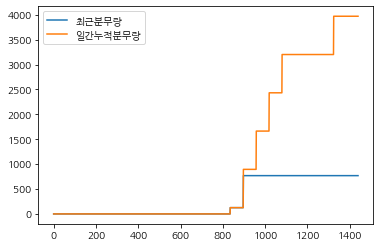

In [145]:
CASE_02[CASE_02['일자'] == datetime.date(2021, 3, 26)][['최근분무량','일간누적분무량']].plot()
# 만약 CASE_10에서도 그래프가 이런 형태로 나온다면 가설이 맞음

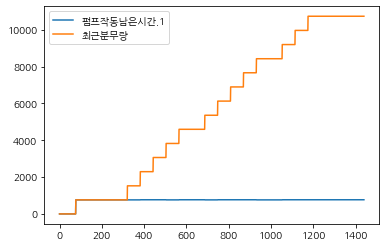

In [146]:
CASE_10['시간'] = pd.to_datetime(CASE_10['시간'])
CASE_10['일자'] = CASE_10['시간'].dt.date
CASE_10['일자'].unique()
CASE_10[CASE_10['일자'] == datetime.date(2021, 4, 6)][['펌프작동남은시간.1','최근분무량']].plot()

In [147]:
# CASE 18도 확인
CASE_18 = pd.read_csv('drive/MyDrive/mini_DNN/open/train_input/CASE_18.csv')
CASE_18[['펌프작동남은시간','펌프작동남은시간.1','최근분무량']]

,펌프작동남은시간,펌프작동남은시간.1,최근분무량
0,0.0,0.00,0.00
1,0.0,0.00,0.00
2,0.0,0.00,0.00
3,0.0,0.00,0.00
4,0.0,0.00,0.00
...,...,...,...
60475,0.0,762.57,12021.08
60476,0.0,762.57,12021.08
60477,0.0,762.57,12021.08
60478,0.0,762.57,12021.08


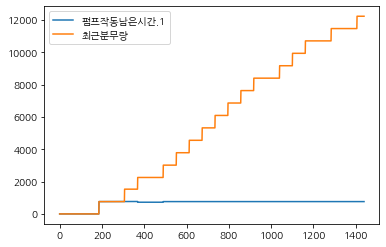

In [148]:
CASE_18['시간'] = pd.to_datetime(CASE_18['시간'])
CASE_18['일자'] = CASE_18['시간'].dt.date
CASE_18['일자'].unique()
CASE_18[CASE_18['일자'] == datetime.date(2021, 6, 3)][['펌프작동남은시간.1','최근분무량']].plot()

결론

-> '펌프작동누적시간.1' 이 있는 데이터들 (case10, case18)의 경우,

`펌프작동누적시간.1`을 `최근분무량`으로, `최근분무량`을 `누적분무량`으로 바꾸어주어야 한다.

In [149]:
train_datasets = []

for n, i in enumerate(train_case):
    data = pd.read_csv(i)
    data['case'] = n+1
    if n in [9,17]:
        train_datasets.append(data.rename(columns = {'최근분무량' : '일간누적분무량', '펌프작동남은시간.1' : '최근분무량',
                            '외부온도추정관측치' : '외부온도관측치', '외부습도추정관측치' : '외부습도관측치'}))
    else : 
        train_datasets.append(data.rename(columns = {'펌프일간누적분무량' : '일간누적분무량', '펌프최근분무량' : '최근분무량', 
                                '외부온도추정관측치' : '외부온도관측치', '외부습도추정관측치' : '외부습도관측치'}))

In [150]:
check_col = []
for j in train_datasets:
    check_col.extend(list(j.columns))
    # print(j.shape)
len(set(check_col))

39

In [151]:
x = pd.concat(train_datasets, ignore_index = True)
x

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,case
0,2021-02-17 00:00:00,24.799999,40.500000,361.0,0.059069,20.299999,33.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,394.0,100.0,201.0,370.0,10.0,201.0,372.0,25.0,0.0,25.0,23.0,24.0,4.5,0.0,0.0,363.554,16.548,37.596000,363.554,309.41,16.548,37.596,1
1,2021-02-17 00:01:00,20.500000,44.099998,355.0,0.910134,19.700001,10.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,62.0,0.0,201.0,64.0,0.0,201.0,66.0,0.0,0.0,20.0,18.0,19.000,0.000,2.500000,0.000,0.00,0.000,0.000,1
2,2021-02-17 00:02:00,20.600000,44.299999,360.0,0.910134,19.799999,10.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,179.0,0.0,201.0,182.0,0.0,201.0,184.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000,1
3,2021-02-17 00:03:00,20.600000,44.500000,359.0,0.908579,19.799999,10.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,117.0,0.0,201.0,120.0,0.0,201.0,122.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000,1
4,2021-02-17 00:04:00,20.600000,44.500000,357.0,0.910134,19.799999,10.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,57.0,0.0,201.0,60.0,0.0,201.0,62.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611502,2022-06-14 23:55:00,21.299999,60.599998,419.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3552.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,167.0,0.0,201.0,169.0,0.0,201.0,171.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58
2611503,2022-06-14 23:56:00,21.299999,60.599998,418.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3577.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,132.0,0.0,201.0,134.0,0.0,201.0,136.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58
2611504,2022-06-14 23:57:00,21.299999,60.599998,416.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3561.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,49.0,0.0,201.0,51.0,0.0,201.0,53.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58
2611505,2022-06-14 23:58:00,21.299999,60.599998,420.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3549.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,162.0,0.0,201.0,164.0,0.0,201.0,166.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58


In [152]:
target_data = []
for n, i in enumerate(train_target):
    data = pd.read_csv(i)
    data['case'] = n + 1
    target_data.append(data)
y = pd.concat(target_data, ignore_index = True)
y

,시간,rate,case
0,2021-02-18 00:00:00,0.50000,1
1,2021-02-19 00:00:00,0.66667,1
2,2021-02-20 00:00:00,0.60000,1
3,2021-02-21 00:00:00,-0.12500,1
4,2021-02-22 00:00:00,1.42857,1
...,...,...,...
1808,2022-06-11 00:00:00,-0.07888,58
1809,2022-06-12 00:00:00,-0.15838,58
1810,2022-06-13 00:00:00,-0.47374,58
1811,2022-06-14 00:00:00,-0.51767,58


# 전처리 및 EDA

### '일자' 파생변수 만들기
- target은 1일 단위인데, feature 데이터는 1분 단위이므로,
'시간'을 datetime 형으로 바꾸어 '일자' 생성

In [153]:
# x와 y의 날짜를 맞춰주기 위해 x의 일자에 1을 더해줘야 한다.
# 24시간동안의 환경을 바탕으로 다음날 00시의 성장률을 측정하기 때문..!

x['시간'] = pd.to_datetime(x['시간'])
x['일자'] = x['시간'].dt.date + datetime.timedelta(days=1)
x['일자'].head()

0    2021-02-18
1    2021-02-18
2    2021-02-18
3    2021-02-18
4    2021-02-18
Name: 일자, dtype: object

### 데이터 형태 및 기술통계값 살펴보기

In [154]:
x

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,case,일자
0,2021-02-17 00:00:00,24.799999,40.500000,361.0,0.059069,20.299999,33.200001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,394.0,100.0,201.0,370.0,10.0,201.0,372.0,25.0,0.0,25.0,23.0,24.0,4.5,0.0,0.0,363.554,16.548,37.596000,363.554,309.41,16.548,37.596,1,2021-02-18
1,2021-02-17 00:01:00,20.500000,44.099998,355.0,0.910134,19.700001,10.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,62.0,0.0,201.0,64.0,0.0,201.0,66.0,0.0,0.0,20.0,18.0,19.000,0.000,2.500000,0.000,0.00,0.000,0.000,1,2021-02-18
2,2021-02-17 00:02:00,20.600000,44.299999,360.0,0.910134,19.799999,10.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,179.0,0.0,201.0,182.0,0.0,201.0,184.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000,1,2021-02-18
3,2021-02-17 00:03:00,20.600000,44.500000,359.0,0.908579,19.799999,10.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,117.0,0.0,201.0,120.0,0.0,201.0,122.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000,1,2021-02-18
4,2021-02-17 00:04:00,20.600000,44.500000,357.0,0.910134,19.799999,10.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,57.0,0.0,201.0,60.0,0.0,201.0,62.0,0.0,0.0,20.0,18.0,19.000,0.000,3.000002,0.000,0.00,0.000,0.000,1,2021-02-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611502,2022-06-14 23:55:00,21.299999,60.599998,419.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3552.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,167.0,0.0,201.0,169.0,0.0,201.0,171.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58,2022-06-15
2611503,2022-06-14 23:56:00,21.299999,60.599998,418.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3577.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,132.0,0.0,201.0,134.0,0.0,201.0,136.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58,2022-06-15
2611504,2022-06-14 23:57:00,21.299999,60.599998,416.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3561.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,49.0,0.0,201.0,51.0,0.0,201.0,53.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58,2022-06-15
2611505,2022-06-14 23:58:00,21.299999,60.599998,420.0,0.008531,25.200001,41.500000,0.0,0.0,769.0,13073.0,201.0,3549.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,162.0,0.0,201.0,164.0,0.0,201.0,166.0,0.0,0.0,16.0,14.0,15.000,0.000,36.499996,0.000,0.00,0.000,0.000,58,2022-06-15


In [155]:
x.shape

(2611507, 40)

In [156]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611507 entries, 0 to 2611506
Data columns (total 40 columns):
 #   Column         Dtype         
---  ------         -----         
 0   시간             datetime64[ns]
 1   내부온도관측치        float64       
 2   내부습도관측치        float64       
 3   CO2관측치         float64       
 4   EC관측치          float64       
 5   외부온도관측치        float64       
 6   외부습도관측치        float64       
 7   펌프상태           float64       
 8   펌프작동남은시간       float64       
 9   최근분무량          float64       
 10  일간누적분무량        float64       
 11  냉방상태           float64       
 12  냉방작동남은시간       float64       
 13  난방상태           float64       
 14  난방작동남은시간       float64       
 15  내부유동팬상태        float64       
 16  내부유동팬작동남은시간    float64       
 17  외부환기팬상태        float64       
 18  외부환기팬작동남은시간    float64       
 19  화이트 LED상태      float64       
 20  화이트 LED작동남은시간  float64       
 21  화이트 LED동작강도    float64       
 22  레드 LED상태       float64       
 23  레드 LED작

In [157]:
# 다운캐스팅 해주자
for col in x.columns:
    if x[col].dtype.name.startswith('float'):
        x[col] = pd.to_numeric(x[col], downcast= 'float')
    elif(x[col].dtype.name.startswith('int')):
        x[col] = pd.to_numeric(x[col], downcast= 'unsigned')

In [158]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611507 entries, 0 to 2611506
Data columns (total 40 columns):
 #   Column         Dtype         
---  ------         -----         
 0   시간             datetime64[ns]
 1   내부온도관측치        float32       
 2   내부습도관측치        float32       
 3   CO2관측치         float32       
 4   EC관측치          float32       
 5   외부온도관측치        float32       
 6   외부습도관측치        float32       
 7   펌프상태           float32       
 8   펌프작동남은시간       float32       
 9   최근분무량          float32       
 10  일간누적분무량        float32       
 11  냉방상태           float32       
 12  냉방작동남은시간       float32       
 13  난방상태           float32       
 14  난방작동남은시간       float32       
 15  내부유동팬상태        float32       
 16  내부유동팬작동남은시간    float32       
 17  외부환기팬상태        float32       
 18  외부환기팬작동남은시간    float32       
 19  화이트 LED상태      float32       
 20  화이트 LED작동남은시간  float32       
 21  화이트 LED동작강도    float32       
 22  레드 LED상태       float32       
 23  레드 LED작

In [159]:
x.nunique()
# 내부유동팬상태 컬럼은 고유값이 8개밖에 없는 것이 눈에 띈다.

시간               479520
내부온도관측치           38066
내부습도관측치           66750
CO2관측치            38705
EC관측치            166933
외부온도관측치           50155
외부습도관측치           74405
펌프상태                526
펌프작동남은시간           2072
최근분무량               114
일간누적분무량           13941
냉방상태              14817
냉방작동남은시간          18933
난방상태                 86
난방작동남은시간            576
내부유동팬상태               8
내부유동팬작동남은시간        3197
외부환기팬상태            1989
외부환기팬작동남은시간        2597
화이트 LED상태         17416
화이트 LED작동남은시간     21357
화이트 LED동작강도        2506
레드 LED상태          17413
레드 LED작동남은시간      21702
레드 LED동작강도         5131
블루 LED상태          17421
블루 LED작동남은시간      21603
블루 LED동작강도         2280
카메라상태              8507
냉방온도             504002
난방온도             495604
기준온도             514375
난방부하              85956
냉방부하             491813
총추정광량             12927
백색광추정광량            4350
적색광추정광량            4889
청색광추정광량            5480
case                 58
일자                  333
dtype: int64

In [160]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
내부온도관측치,2538185.0,24.485765,4.096520e+00,0.000000,22.100000,24.850000,27.299999,4.501667e+01
내부습도관측치,2538185.0,70.308258,5.041845e+03,0.000000,58.099998,69.800003,78.900002,8.001986e+06
CO2관측치,2538185.0,502.262573,1.379173e+02,0.000000,422.000000,481.000000,560.000000,3.259000e+03
EC관측치,2538185.0,1.910332,3.430858e+00,-0.559782,0.545614,1.356623,2.182126,3.542000e+03
외부온도관측치,2198649.0,24.364288,6.681657e+00,0.000000,21.400000,23.820000,26.799999,9.080000e+01
외부습도관측치,2198649.0,36.783901,1.835927e+01,0.000000,22.520000,34.160000,50.299999,2.010000e+02
펌프상태,2538185.0,3.509226,2.623644e+01,0.000000,0.000000,0.000000,0.000000,2.010000e+02
펌프작동남은시간,2538185.0,9.700955,8.280084e+02,0.000000,0.000000,0.000000,0.000000,9.999900e+04
최근분무량,2538185.0,1005.241272,1.865740e+04,0.000000,126.000000,582.530029,769.000000,6.429974e+05
일간누적분무량,2538185.0,7871.051270,6.036455e+04,0.000000,769.000000,2959.699951,6908.140137,3.214055e+06


In [161]:
# x.hist(figsize = (30,30));
# plt.tight_layout()

In [162]:
# 히스토그램을 보니, 대부분의 값들이 0에 몰려있는 것 같은 기분이 든다...
# 아니었으면 좋겠다...!
# 그리고 스케일링은 필수다!

### 결측치 확인 및 처리

In [163]:
# 결측치가 많다...!
x.isnull().sum()

시간                    0
내부온도관측치           73322
내부습도관측치           73322
CO2관측치            73322
EC관측치             73322
외부온도관측치          412858
외부습도관측치          412858
펌프상태              73322
펌프작동남은시간          73322
최근분무량             73322
일간누적분무량           73322
냉방상태              73322
냉방작동남은시간          73322
난방상태              73322
난방작동남은시간          73322
내부유동팬상태           73322
내부유동팬작동남은시간       73322
외부환기팬상태           73322
외부환기팬작동남은시간       73322
화이트 LED상태         73322
화이트 LED작동남은시간     73322
화이트 LED동작강도       73322
레드 LED상태          73322
레드 LED작동남은시간      73322
레드 LED동작강도        73322
블루 LED상태          73322
블루 LED작동남은시간      73322
블루 LED동작강도        73322
카메라상태             73322
냉방온도              73322
난방온도              73322
기준온도              73322
난방부하              73322
냉방부하              73322
총추정광량             73322
백색광추정광량           73322
적색광추정광량           73322
청색광추정광량           73322
case                  0
일자                    0
dtype: int64

In [164]:
# 결측치를 heatmap으로 파악
# plt.figure(figsize = (30,30))
# sns.heatmap(x.isnull(), cmap = 'gray')

In [165]:
# 합쳐진 데이터에서 결측치가 있는 곳 보기
# 외부온도관측치가 결측치이 곳들에 결측치가 많다.
miss_idx = list(x.loc[x['외부온도관측치'].isnull()].index)

In [166]:
# 통째 결측치인 곳도 있지만, 외부온도관측치와 외부습도 관측치만 결측치인 행들도 많다.
# 이름을 바꾸며 데이터를 합쳐줄때 문제가 있었는지 파악하기 위해 해당 부분의 원본 데이터를 찾아봐야겠다.
x.loc[miss_idx]

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,case,일자
25395,2021-03-06 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2021-03-07
38473,2021-03-15 17:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2021-03-16
54784,2021-04-04 01:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2021-04-05
137456,2021-04-05 10:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2021-04-06
207066,2021-03-26 19:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2021-03-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493422,2022-05-13 23:55:00,25.299999,66.199997,367.0,5.004014,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3550.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,111.0,100.0,201.0,113.0,60.0,201.0,115.0,50.0,0.0,21.0,20.0,20.5,0.0,26.499996,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493423,2022-05-13 23:56:00,25.100000,68.000000,346.0,5.002966,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3560.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,60.0,100.0,201.0,62.0,60.0,201.0,64.0,50.0,0.0,21.0,20.0,20.5,0.0,26.499996,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493424,2022-05-13 23:57:00,25.100000,68.500000,343.0,5.009252,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3556.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,97.0,100.0,201.0,99.0,60.0,201.0,102.0,50.0,0.0,21.0,20.0,20.5,0.0,26.499996,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493425,2022-05-13 23:58:00,25.100000,69.000000,335.0,5.004014,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3560.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,40.0,100.0,201.0,42.0,60.0,201.0,45.0,50.0,0.0,21.0,20.0,20.5,0.0,25.500002,487.02301,309.410004,99.288002,78.324997,55,2022-05-14


#### 원본 데이터의 결측치 파악하기
- 결측치가 생각보다 너무 많다.
- 혹시 합쳐주는 과정에서 문제가 있었던 것 인지 확인하기 위해 원본 데이터의 결측치를 확인한다.

In [167]:
# 원본 데이터의 결측치 살펴보기
# 원본 자체에 결측치가 많았다...!
# for i in train_case:
#     print(i[-11:-4], '의 결측치 수 : ',pd.read_csv(i).isnull().sum().sum())

In [168]:
# case 45가 결측치가 가장 많아보이니까 한번 탐색해보자.
case_45 = pd.read_csv(train_case[44])
case_45.isnull().sum()

시간                   0
내부온도관측치          15874
내부습도관측치          15874
CO2관측치           15874
EC관측치            15874
외부온도추정관측치        15874
외부습도추정관측치        15874
펌프상태             15874
펌프작동남은시간         15874
펌프최근분무량          15874
펌프일간누적분무량        15874
냉방상태             15874
냉방작동남은시간         15874
난방상태             15874
난방작동남은시간         15874
내부유동팬상태          15874
내부유동팬작동남은시간      15874
외부환기팬상태          15874
외부환기팬작동남은시간      15874
화이트 LED상태        15874
화이트 LED작동남은시간    15874
화이트 LED동작강도      15874
레드 LED상태         15874
레드 LED작동남은시간     15874
레드 LED동작강도       15874
블루 LED상태         15874
블루 LED작동남은시간     15874
블루 LED동작강도       15874
카메라상태            15874
냉방온도             15874
난방온도             15874
기준온도             15874
난방부하             15874
냉방부하             15874
총추정광량            15874
백색광추정광량          15874
적색광추정광량          15874
청색광추정광량          15874
dtype: int64

In [169]:
# 이렇게 통째로 결측치인 행들이 원본 데이터에 섞여있다.
case_45[case_45['외부온도추정관측치'].isnull()]

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도추정관측치,외부습도추정관측치,펌프상태,펌프작동남은시간,펌프최근분무량,펌프일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
2400,2022-03-23 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2401,2022-03-23 16:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2402,2022-03-23 16:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2403,2022-03-23 16:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2404,2022-03-23 16:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57535,2022-04-30 22:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57540,2022-04-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57558,2022-04-30 23:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57576,2022-04-30 23:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
# 외부온도 및 외부습도만 결측치인 행에 주목
x.loc[miss_idx].tail()

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,case,일자
2493422,2022-05-13 23:55:00,25.299999,66.199997,367.0,5.004014,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3550.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,111.0,100.0,201.0,113.0,60.0,201.0,115.0,50.0,0.0,21.0,20.0,20.5,0.0,26.499996,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493423,2022-05-13 23:56:00,25.100000,68.000000,346.0,5.002966,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3560.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,60.0,100.0,201.0,62.0,60.0,201.0,64.0,50.0,0.0,21.0,20.0,20.5,0.0,26.499996,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493424,2022-05-13 23:57:00,25.100000,68.500000,343.0,5.009252,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3556.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,97.0,100.0,201.0,99.0,60.0,201.0,102.0,50.0,0.0,21.0,20.0,20.5,0.0,26.499996,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493425,2022-05-13 23:58:00,25.100000,69.000000,335.0,5.004014,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3560.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,40.0,100.0,201.0,42.0,60.0,201.0,45.0,50.0,0.0,21.0,20.0,20.5,0.0,25.500002,487.02301,309.410004,99.288002,78.324997,55,2022-05-14
2493426,2022-05-13 23:59:00,25.100000,61.900002,340.0,5.004014,NaN,NaN,0.0,0.0,769.0,13073.0,201.0,3564.0,0.0,0.0,0.0,0.0,201.0,83.0,201.0,104.0,100.0,201.0,106.0,60.0,201.0,108.0,50.0,0.0,21.0,20.0,20.5,0.0,25.500002,487.02301,309.410004,99.288002,78.324997,55,2022-05-14


In [171]:
# 저 index가 2493422인 것은 원본 데이터 파일 중 어느 데이터에 속한 것인지 알아보자.
# case 55이다.
# idx = 0
# for i in train_case:
#     idx += len(pd.read_csv(i))
#     print(i[-11:-4], '까지의 인덱스 :', idx)

In [172]:
# 원본에서도 외부 온도 및 외부 습도만 결측치였던 것으로 확인된다.
# 신경 안써줘도 되겠다.
case_55 = pd.read_csv(train_case[-4])
case_55.head()

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도추정관측치,외부습도추정관측치,펌프상태,펌프작동남은시간,펌프최근분무량,펌프일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2022-04-26 00:00:00,26.299999,55.299999,504.0,3.829706,NaN,NaN,0.0,0.0,0.0,0.0,201.0,3547.0,0.0,0.0,201.0,56383.0,0.0,0.0,201.0,107.0,41.0,201.0,109.0,24.0,201.0,111.0,20.0,201.0,21.0,20.0,20.5,0.0,32.500000,197.9033,126.8581,39.7152,31.33
1,2022-04-26 00:01:00,26.200001,55.500000,501.0,3.831801,NaN,NaN,0.0,0.0,0.0,0.0,201.0,3549.0,0.0,0.0,201.0,56321.0,0.0,0.0,201.0,56.0,41.0,201.0,58.0,24.0,201.0,60.0,20.0,0.0,21.0,20.0,20.5,0.0,32.500000,197.9033,126.8581,39.7152,31.33
2,2022-04-26 00:02:00,25.900000,55.489999,505.0,3.831862,NaN,NaN,0.0,0.0,0.0,0.0,201.0,3599.0,0.0,0.0,201.0,56250.0,0.0,0.0,201.0,95.0,0.0,201.0,97.0,0.0,201.0,99.0,0.0,0.0,21.0,20.0,20.5,0.0,31.499996,0.0000,0.0000,0.0000,0.00
3,2022-04-26 00:03:00,25.600000,55.559999,498.0,3.832434,NaN,NaN,0.0,0.0,0.0,0.0,201.0,3545.0,0.0,0.0,201.0,56200.0,0.0,0.0,201.0,45.0,0.0,201.0,47.0,0.0,201.0,49.0,0.0,0.0,21.0,20.0,20.5,0.0,29.499998,0.0000,0.0000,0.0000,0.00
4,2022-04-26 00:04:00,25.400000,55.629999,500.0,3.833007,NaN,NaN,0.0,0.0,0.0,0.0,201.0,3546.0,0.0,0.0,201.0,56140.0,0.0,0.0,201.0,107.0,0.0,201.0,109.0,0.0,201.0,111.0,0.0,0.0,21.0,20.0,20.5,0.0,29.499998,0.0000,0.0000,0.0000,0.00


#### 결측치 처리

In [173]:
# 중요한 것은, 특정 '날짜'에 결측치가 몰려있느냐 그렇지 않느냐이다.
# 어차피 1분 간격의 데이터를 1일 단위로 종합하여 예측에 사용해야 하기 때문.
# 하루는 1440분이므로, 결측치의 수가 1440인 날들은 모두 결측치인 셈

missed_day = x.loc[miss_idx].groupby(['일자','case']).size()
all_missed_day = missed_day[missed_day == 1440]
all_missed_day

# 결론
# '외부온도' 컬럼에 결측치가 존재하는 총 387일 중에
# 모두 결측치인 날들은 262일 존재한다.

일자          case
2022-02-24  37      1440
2022-02-25  37      1440
2022-02-26  37      1440
2022-02-27  37      1440
2022-02-28  37      1440
                    ... 
2022-05-25  50      1440
2022-05-26  50      1440
2022-05-27  50      1440
2022-05-28  50      1440
2022-05-29  50      1440
Length: 262, dtype: int64

In [174]:
# 각 case 별 외부온도가 모두 결측치인 날의 수
pd.DataFrame(all_missed_day).reset_index()['case'].value_counts()

37    44
50    39
39    37
49    34
54    27
47    25
55    18
43    17
38     7
41     7
44     7
Name: case, dtype: int64

In [175]:
# 그래서 어떻게 처리할건데?
x.isnull().sum()
# 결측치가 너무 많고, 예측에 사용하지도 않을 컬럼인 외부온도관측치와 외부습도관측치는 제거
# 나머지의 경우, 한 행에 대해 모든 열이 결측치라면 제거
# 아니라면 보간법을 이용해 채워주기

시간                    0
내부온도관측치           73322
내부습도관측치           73322
CO2관측치            73322
EC관측치             73322
외부온도관측치          412858
외부습도관측치          412858
펌프상태              73322
펌프작동남은시간          73322
최근분무량             73322
일간누적분무량           73322
냉방상태              73322
냉방작동남은시간          73322
난방상태              73322
난방작동남은시간          73322
내부유동팬상태           73322
내부유동팬작동남은시간       73322
외부환기팬상태           73322
외부환기팬작동남은시간       73322
화이트 LED상태         73322
화이트 LED작동남은시간     73322
화이트 LED동작강도       73322
레드 LED상태          73322
레드 LED작동남은시간      73322
레드 LED동작강도        73322
블루 LED상태          73322
블루 LED작동남은시간      73322
블루 LED동작강도        73322
카메라상태             73322
냉방온도              73322
난방온도              73322
기준온도              73322
난방부하              73322
냉방부하              73322
총추정광량             73322
백색광추정광량           73322
적색광추정광량           73322
청색광추정광량           73322
case                  0
일자                    0
dtype: int64

In [176]:
x = x.drop(columns = ['외부온도관측치','외부습도관측치'])

In [177]:
# print(len(x))
# x = pd.concat([x.drop(columns = ['일자','case','시간']).dropna(how = 'all'), x[['일자','case','시간']]], axis = 1, join = 'inner')
# print(len(x))
# x.isnull().sum()


## 결측치가 존재하는 행에서는 모든 값이 결측치이다.
## 어차피 일 단위로 묶어줄거니까, 다른 처리 해주지 않고, 묶자!
## groupby 한 후에! 결측치를 고민하자.

## 이상치 파악 및 처리

In [178]:
# 히스토그램을 그려봤을때, 0에 다소 많은 값이 가있는 것을 알 수 있었다.
# 0에 있는 값들을 이상치라고 생각할 수도 있을 것 같다.
# 어떻게 처리해줘야할지 모르겠으므로 패스한다.

## 1일 단위로 묶어주기
- target이 1일 단위이므로, 데이터를 1일 단위로 묶어주자.
- groupby(['case','일자']) 를 이용하자.
- 묶어주며 가져올 컬럼은 다음과 같다.


In [179]:
x.columns

Index(['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '펌프상태', '펌프작동남은시간',
       '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태', '난방작동남은시간', '내부유동팬상태',
       '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간', '화이트 LED상태', '화이트 LED작동남은시간',
       '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간', '레드 LED동작강도', '블루 LED상태',
       '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도', '난방온도', '기준온도', '난방부하',
       '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', 'case', '일자'],
      dtype='object')

In [180]:
x_train = pd.concat([x.groupby(['case','일자']).agg({'내부습도관측치': 'mean', '일간누적분무량' : 'max'}),
x.groupby(['case','일자'])[['내부온도관측치']].mean(),
x.groupby(['case','일자'])['CO2관측치'].sum(),
x.groupby(['case','일자'])['EC관측치'].mean(),
x[x['냉방작동남은시간']!= 0].groupby(['case','일자'])['냉방상태'].count(),
x[x['난방작동남은시간']!= 0].groupby(['case','일자'])['난방상태'].count(),
x[x['외부환기팬상태'] != 0].groupby(['case','일자'])['외부환기팬상태'].count(),
x[x['내부유동팬상태'] != 0].groupby(['case','일자'])['내부유동팬상태'].count(),
x[x['화이트 LED상태'] != 0].groupby(['case','일자'])['화이트 LED상태'].count(),
x[x['블루 LED상태'] != 0].groupby(['case','일자'])['블루 LED상태'].count(),
x[x['레드 LED상태'] != 0].groupby(['case','일자'])['레드 LED상태'].count(),
x.groupby(['case','일자'])[['백색광추정광량','청색광추정광량','적색광추정광량','총추정광량']].sum()], axis = 1)

x_train.columns = ['내부습도평균','일간누적분무량','내부온도평균','CO2총계','EC평균','냉방(분)','난방(분)',
'외부환기(분)','내부유동(분)','화이트LED(분)','블루LED(분)','레드LED(분)','백색광추정광량','청색광추정광량','적색광추정광량','총추정광량']

In [181]:
x_train

내부습도평균       일간누적분무량     내부온도평균     CO2총계      EC평균  \
case 일자                                                                   
1    2021-02-18  28.681458   3845.000000  22.589619  578040.0  0.914168   
     2021-02-19  32.574200  13809.849609  21.982327  525595.0  0.907814   
     2021-02-20  32.688507  11509.280273  21.946354  512013.5  0.906639   
     2021-02-21  26.747639  12265.419922  22.961979  508446.0  0.909431   
     2021-02-22  41.969444  11911.769531  23.568577  551690.0  0.910634   
...                    ...           ...        ...       ...       ...   
58   2022-06-11  64.427292  13073.000000  24.809584  671355.5  0.011782   
     2022-06-12  62.372173  13073.000000  24.573647  714975.5  0.010869   
     2022-06-13  61.645920  13073.000000  24.430586  623225.0  0.009891   
     2022-06-14  62.061214  13073.000000  24.339722  723226.0  0.009580   
     2022-06-15  58.065632  13073.000000  23.977985  607236.0  0.009190   

                  냉방(분)  난방(분)  외부환기(분)  내부유동(분)  화이트LED(분)  블루LED(분)  \
case 일자                                                                 
1    2021-02-18   246.0    NaN    124.0      2.0     1433.0    1433.0   
     2021-02-19   167.0    NaN    291.0      NaN     1428.0    1425.0   
     2021-02-20   227.0    NaN    423.0      NaN     1423.0    1424.0   
     2021-02-21   657.0    NaN    719.0      NaN     1427.0    1426.0   
     2021-02-22  1202.0    NaN    447.0      NaN     1427.0    1429.0   
...                 ...    ...      ...      ...        ...       ...   
58   2022-06-11  1440.0    NaN      NaN      NaN     1434.0    1434.0   
     2022-06-12  1392.0    NaN      NaN      NaN     1424.0    1425.0   
     2022-06-13  1417.0    NaN      NaN      NaN     1437.0    1437.0   
     2022-06-14  1430.0    NaN      NaN      NaN     1431.0    1432.0   
     2022-06-15  1404.0    NaN      NaN      NaN     1436.0    1434.0   

                 레드LED(분)        백색광추정광량       청색광추정광량       적색광추정광량  \
case 일자                                                                
1    2021-02-18    1432.0     309.410004     37.596001     16.548000   
     2021-02-19    1425.0       0.000000      0.000000      0.000000   
     2021-02-20    1421.0       0.000000      0.000000      0.000000   
     2021-02-21    1428.0       0.000000      0.000000      0.000000   
     2021-02-22    1430.0       0.000000      0.000000      0.000000   
...                   ...            ...           ...           ...   
58   2022-06-11    1434.0  210267.296875  30430.828125  17820.541016   
     2022-06-12    1425.0  210301.343750  30408.898438  17803.994141   
     2022-06-13    1437.0  210233.265625  30416.730469  17821.369141   
     2022-06-14    1432.0  210196.140625  30439.445312  17802.337891   
     2022-06-15    1435.0  210241.000000  30413.597656  17850.328125   

                         총추정광량  
case 일자                         
1    2021-02-18     363.553986  
     2021-02-19       0.000000  
     2021-02-20       0.000000  
     2021-02-21       0.000000  
     2021-02-22       0.000000  
...                        ...  
58   2022-06-11  258518.671875  
     2022-06-12  258514.234375  
     2022-06-13  258471.359375  
     2022-06-14  258437.921875  
     2022-06-15  258504.921875  

[1814 rows x 16 columns]

In [182]:
x_train.isnull().sum()

내부습도평균         22
일간누적분무량        22
내부온도평균         22
CO2총계           0
EC평균           22
냉방(분)          46
난방(분)        1311
외부환기(분)       545
내부유동(분)      1509
화이트LED(분)      30
블루LED(분)        1
레드LED(분)        1
백색광추정광량         0
청색광추정광량         0
적색광추정광량         0
총추정광량           0
dtype: int64

# feature + target

In [183]:
y['시간'] = pd.to_datetime(y['시간'])
y['일자'] = y['시간'].dt.date
y = y.drop(columns = '시간')
y

,rate,case,일자
0,0.50000,1,2021-02-18
1,0.66667,1,2021-02-19
2,0.60000,1,2021-02-20
3,-0.12500,1,2021-02-21
4,1.42857,1,2021-02-22
...,...,...,...
1808,-0.07888,58,2022-06-11
1809,-0.15838,58,2022-06-12
1810,-0.47374,58,2022-06-13
1811,-0.51767,58,2022-06-14


In [184]:
y

,rate,case,일자
0,0.50000,1,2021-02-18
1,0.66667,1,2021-02-19
2,0.60000,1,2021-02-20
3,-0.12500,1,2021-02-21
4,1.42857,1,2021-02-22
...,...,...,...
1808,-0.07888,58,2022-06-11
1809,-0.15838,58,2022-06-12
1810,-0.47374,58,2022-06-13
1811,-0.51767,58,2022-06-14


In [185]:
x_train = x_train.reset_index()
x_train

,case,일자,내부습도평균,일간누적분무량,내부온도평균,CO2총계,EC평균,냉방(분),난방(분),외부환기(분),내부유동(분),화이트LED(분),블루LED(분),레드LED(분),백색광추정광량,청색광추정광량,적색광추정광량,총추정광량
0,1,2021-02-18,28.681458,3845.000000,22.589619,578040.0,0.914168,246.0,NaN,124.0,2.0,1433.0,1433.0,1432.0,309.410004,37.596001,16.548000,363.553986
1,1,2021-02-19,32.574200,13809.849609,21.982327,525595.0,0.907814,167.0,NaN,291.0,NaN,1428.0,1425.0,1425.0,0.000000,0.000000,0.000000,0.000000
2,1,2021-02-20,32.688507,11509.280273,21.946354,512013.5,0.906639,227.0,NaN,423.0,NaN,1423.0,1424.0,1421.0,0.000000,0.000000,0.000000,0.000000
3,1,2021-02-21,26.747639,12265.419922,22.961979,508446.0,0.909431,657.0,NaN,719.0,NaN,1427.0,1426.0,1428.0,0.000000,0.000000,0.000000,0.000000
4,1,2021-02-22,41.969444,11911.769531,23.568577,551690.0,0.910634,1202.0,NaN,447.0,NaN,1427.0,1429.0,1430.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,58,2022-06-11,64.427292,13073.000000,24.809584,671355.5,0.011782,1440.0,NaN,NaN,NaN,1434.0,1434.0,1434.0,210267.296875,30430.828125,17820.541016,258518.671875
1810,58,2022-06-12,62.372173,13073.000000,24.573647,714975.5,0.010869,1392.0,NaN,NaN,NaN,1424.0,1425.0,1425.0,210301.343750,30408.898438,17803.994141,258514.234375
1811,58,2022-06-13,61.645920,13073.000000,24.430586,623225.0,0.009891,1417.0,NaN,NaN,NaN,1437.0,1437.0,1437.0,210233.265625,30416.730469,17821.369141,258471.359375
1812,58,2022-06-14,62.061214,13073.000000,24.339722,723226.0,0.009580,1430.0,NaN,NaN,NaN,1431.0,1432.0,1432.0,210196.140625,30439.445312,17802.337891,258437.921875


In [186]:
# 전체 데이터
df = x_train.merge(y, on = ['case','일자'])
df

,case,일자,내부습도평균,일간누적분무량,내부온도평균,CO2총계,EC평균,냉방(분),난방(분),외부환기(분),내부유동(분),화이트LED(분),블루LED(분),레드LED(분),백색광추정광량,청색광추정광량,적색광추정광량,총추정광량,rate
0,1,2021-02-18,28.681458,3845.000000,22.589619,578040.0,0.914168,246.0,NaN,124.0,2.0,1433.0,1433.0,1432.0,309.410004,37.596001,16.548000,363.553986,0.50000
1,1,2021-02-19,32.574200,13809.849609,21.982327,525595.0,0.907814,167.0,NaN,291.0,NaN,1428.0,1425.0,1425.0,0.000000,0.000000,0.000000,0.000000,0.66667
2,1,2021-02-20,32.688507,11509.280273,21.946354,512013.5,0.906639,227.0,NaN,423.0,NaN,1423.0,1424.0,1421.0,0.000000,0.000000,0.000000,0.000000,0.60000
3,1,2021-02-21,26.747639,12265.419922,22.961979,508446.0,0.909431,657.0,NaN,719.0,NaN,1427.0,1426.0,1428.0,0.000000,0.000000,0.000000,0.000000,-0.12500
4,1,2021-02-22,41.969444,11911.769531,23.568577,551690.0,0.910634,1202.0,NaN,447.0,NaN,1427.0,1429.0,1430.0,0.000000,0.000000,0.000000,0.000000,1.42857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,58,2022-06-11,64.427292,13073.000000,24.809584,671355.5,0.011782,1440.0,NaN,NaN,NaN,1434.0,1434.0,1434.0,210267.296875,30430.828125,17820.541016,258518.671875,-0.07888
1809,58,2022-06-12,62.372173,13073.000000,24.573647,714975.5,0.010869,1392.0,NaN,NaN,NaN,1424.0,1425.0,1425.0,210301.343750,30408.898438,17803.994141,258514.234375,-0.15838
1810,58,2022-06-13,61.645920,13073.000000,24.430586,623225.0,0.009891,1417.0,NaN,NaN,NaN,1437.0,1437.0,1437.0,210233.265625,30416.730469,17821.369141,258471.359375,-0.47374
1811,58,2022-06-14,62.061214,13073.000000,24.339722,723226.0,0.009580,1430.0,NaN,NaN,NaN,1431.0,1432.0,1432.0,210196.140625,30439.445312,17802.337891,258437.921875,-0.51767


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1813 entries, 0 to 1812
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   case       1813 non-null   int64  
 1   일자         1813 non-null   object 
 2   내부습도평균     1791 non-null   float32
 3   일간누적분무량    1791 non-null   float32
 4   내부온도평균     1791 non-null   float32
 5   CO2총계      1813 non-null   float32
 6   EC평균       1791 non-null   float32
 7   냉방(분)      1767 non-null   float64
 8   난방(분)      502 non-null    float64
 9   외부환기(분)    1268 non-null   float64
 10  내부유동(분)    304 non-null    float64
 11  화이트LED(분)  1783 non-null   float64
 12  블루LED(분)   1812 non-null   float64
 13  레드LED(분)   1812 non-null   float64
 14  백색광추정광량    1813 non-null   float32
 15  청색광추정광량    1813 non-null   float32
 16  적색광추정광량    1813 non-null   float32
 17  총추정광량      1813 non-null   float32
 18  rate       1813 non-null   float64
dtypes: float32(9), float64(8), int64(1), object(1)
m

In [188]:
df.isnull().sum()

case            0
일자              0
내부습도평균         22
일간누적분무량        22
내부온도평균         22
CO2총계           0
EC평균           22
냉방(분)          46
난방(분)        1311
외부환기(분)       545
내부유동(분)      1509
화이트LED(분)      30
블루LED(분)        1
레드LED(분)        1
백색광추정광량         0
청색광추정광량         0
적색광추정광량         0
총추정광량           0
rate            0
dtype: int64

In [189]:
df = df.fillna(0)

In [190]:
df.isnull().sum()

case         0
일자           0
내부습도평균       0
일간누적분무량      0
내부온도평균       0
CO2총계        0
EC평균         0
냉방(분)        0
난방(분)        0
외부환기(분)      0
내부유동(분)      0
화이트LED(분)    0
블루LED(분)     0
레드LED(분)     0
백색광추정광량      0
청색광추정광량      0
적색광추정광량      0
총추정광량        0
rate         0
dtype: int64

## 시각화

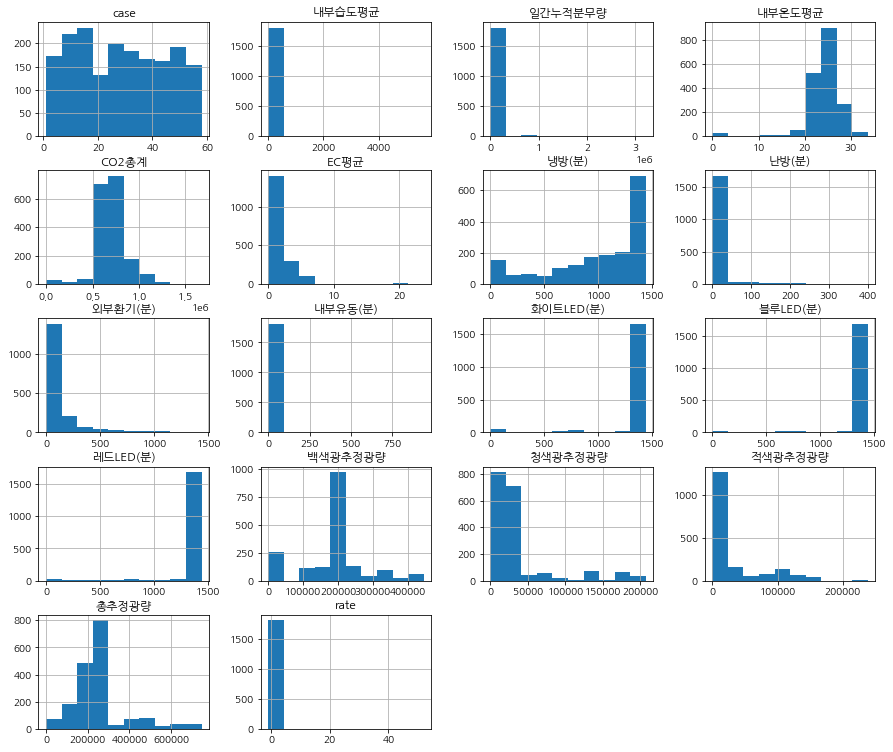

In [191]:
df.hist(figsize = (15,13));

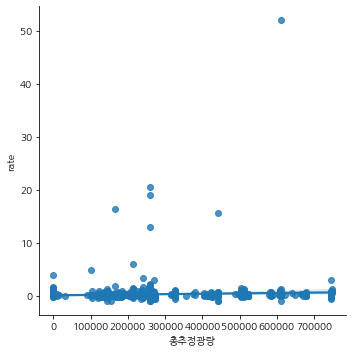

In [192]:
sns.lmplot(data = df, x='총추정광량', y='rate')

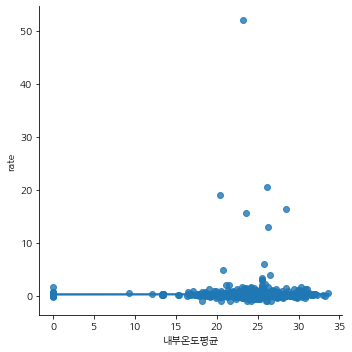

In [193]:
sns.lmplot(data =df, x='내부온도평균', y='rate')

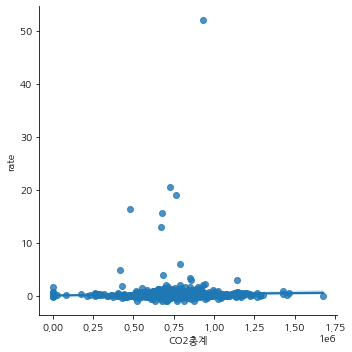

In [194]:
sns.lmplot(data = df, x ='CO2총계', y='rate')

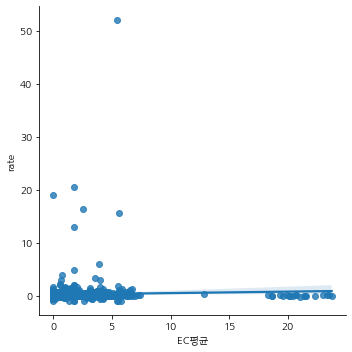

In [195]:
sns.lmplot(data = df, x ='EC평균', y='rate')

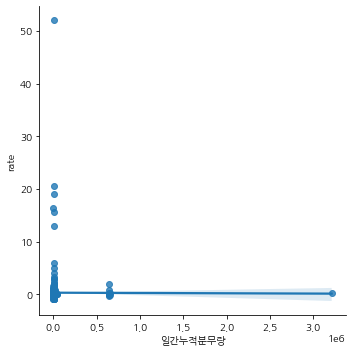

In [196]:
sns.lmplot(data = df, x ='일간누적분무량', y='rate')

In [197]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))

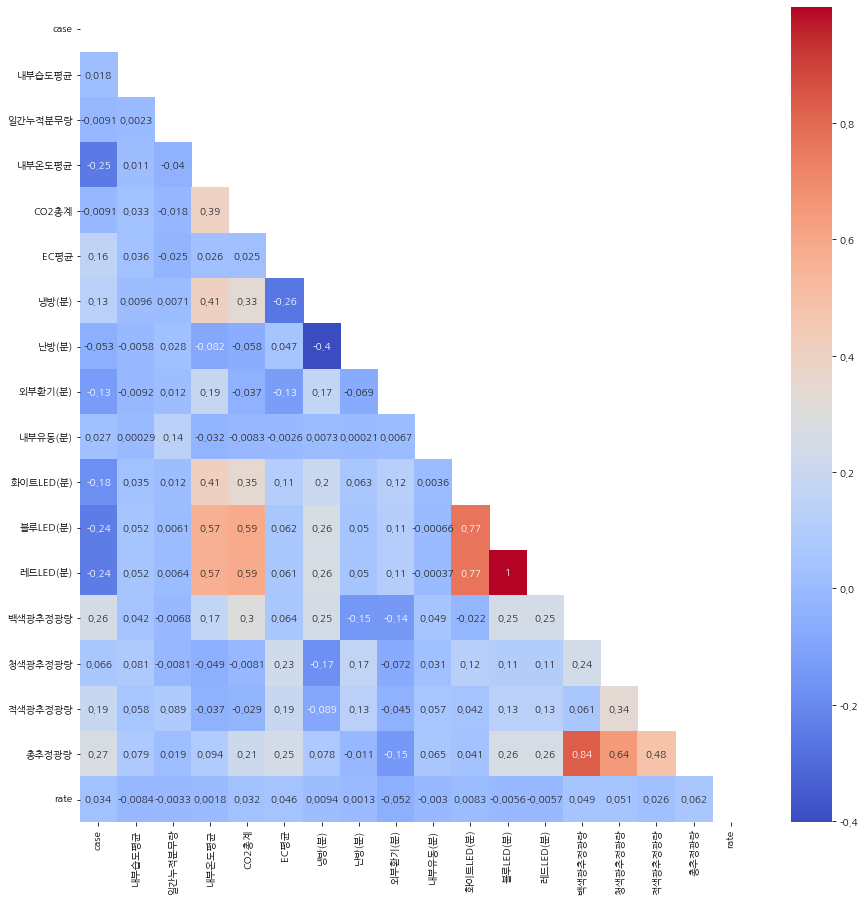

In [198]:
# 큰 상관관계를 보이는 컬럼들이 없다...
# 전처리 방향을 잘못해줬나..

plt.figure(figsize = (15,15))
sns.heatmap(corr, mask = mask, annot = True, cmap = 'coolwarm')

## 스케일링
- 회귀모델인 만큼 스케일링은 필수이다.
- robust scaling을 이용하자.

In [199]:
# robust scaling을 이용하자.
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_std = scaler.fit_transform(df.drop(columns = ['일자','case','rate']))

In [200]:
dropped_col = list(df.drop(columns = ['일자','case','rate']).columns)
dropped_col

['내부습도평균',
 '일간누적분무량',
 '내부온도평균',
 'CO2총계',
 'EC평균',
 '냉방(분)',
 '난방(분)',
 '외부환기(분)',
 '내부유동(분)',
 '화이트LED(분)',
 '블루LED(분)',
 '레드LED(분)',
 '백색광추정광량',
 '청색광추정광량',
 '적색광추정광량',
 '총추정광량']

In [201]:
train_std = pd.concat([pd.DataFrame(df_std, columns = dropped_col), df[['일자','case','rate']]], axis = 1)
train_std

,내부습도평균,일간누적분무량,내부온도평균,CO2총계,EC평균,냉방(분),난방(분),외부환기(분),내부유동(분),화이트LED(분),블루LED(분),레드LED(분),백색광추정광량,청색광추정광량,적색광추정광량,총추정광량,일자,case,rate
0,-1.967455,-0.622356,-0.611935,-0.828867,-0.268824,-1.359517,0.0,0.781955,2.0,-0.066667,-0.230769,-0.214286,-3.031066,-0.814936,-0.522446,-3.358234,2021-02-18,1,0.50000
1,-1.779070,0.532225,-0.806697,-1.220125,-0.272950,-1.478852,0.0,2.037594,0.0,-0.400000,-0.846154,-0.714286,-3.035533,-0.816172,-0.522931,-3.362966,2021-02-19,1,0.66667
2,-1.773539,0.265669,-0.818233,-1.321448,-0.273713,-1.388218,0.0,3.030075,0.0,-0.733333,-0.923077,-1.000000,-3.035533,-0.816172,-0.522931,-3.362966,2021-02-20,1,0.60000
3,-2.061041,0.353279,-0.492517,-1.348063,-0.271901,-0.738671,0.0,5.255639,0.0,-0.466667,-0.769231,-0.500000,-3.035533,-0.816172,-0.522931,-3.362966,2021-02-21,1,-0.12500
4,-1.324397,0.312303,-0.297977,-1.025447,-0.271120,0.084592,0.0,3.210526,0.0,-0.466667,-0.538462,-0.357143,-3.035533,-0.816172,-0.522931,-3.362966,2021-02-22,1,1.42857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,-0.237574,0.446850,0.100020,-0.132701,-0.854791,0.444109,0.0,-0.150376,0.0,0.000000,-0.153846,-0.071429,-0.000022,0.183983,-0.000291,0.001671,2022-06-11,58,-0.07888
1809,-0.337029,0.446850,0.024354,0.192719,-0.855384,0.371601,0.0,-0.150376,0.0,-0.666667,-0.846154,-0.714286,0.000469,0.183262,-0.000777,0.001614,2022-06-12,58,-0.15838
1810,-0.372175,0.446850,-0.021526,-0.491771,-0.856019,0.409366,0.0,-0.150376,0.0,0.200000,0.076923,0.142857,-0.000514,0.183520,-0.000267,0.001056,2022-06-13,58,-0.47374
1811,-0.352078,0.446850,-0.050667,0.254271,-0.856221,0.429003,0.0,-0.150376,0.0,-0.200000,-0.307692,-0.214286,-0.001050,0.184266,-0.000825,0.000620,2022-06-14,58,-0.51767


# 학습용 데이터 최종 정리

In [202]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_std.drop(columns =['일자','case','rate']), train_std['rate'], test_size = 0.2)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1450, 16), (363, 16), (1450,), (363,))

In [203]:
feature_name = ['내부습도평균','일간누적분무량','내부온도평균','CO2총계','EC평균','냉방(분)',
    '외부환기(분)','백색광추정광량','청색광추정광량','적색광추정광량','총추정광량']
# '내부유동(분)','화이트LED(분)','블루LED(분)','레드LED(분)','난방(분)' 삭제
# 삭제 전 eval : loss: 9.3522 - root_mean_squared_error: 3.0581
# 삭제 후 eval : loss: 9.2354 - root_mean_squared_error: 3.0390
# 큰 차이 없음!
# 그럼 그냥 빼기로!

# 모델 생성 및 학습
- tensorflow의 DNN을 활용한다.
- 파이팅..!

In [219]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape = [len(feature_name)]),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(512, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [205]:
model.compile(
    loss = 'mean_squared_error',
    metrics = ['RootMeanSquaredError'],
    optimizer = 'adam'
)

In [206]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1536      
                                                                 
 dense_10 (Dense)            (None, 512)               66048     
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [207]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

In [208]:
history = model.fit(x_train[feature_name], y_train, epochs = 10000, validation_split = 0.1, callbacks= [early_stop])

Epoch 1/10000
41/41 [==============================] - 1s 17ms/step - loss: 3.2678 - root_mean_squared_error: 1.8077 - val_loss: 2.5631 - val_root_mean_squared_error: 1.6010
Epoch 2/10000
41/41 [==============================] - 1s 13ms/step - loss: 3.3604 - root_mean_squared_error: 1.8331 - val_loss: 2.7486 - val_root_mean_squared_error: 1.6579
Epoch 3/10000
41/41 [==============================] - 1s 13ms/step - loss: 6.2598 - root_mean_squared_error: 2.5020 - val_loss: 2.6147 - val_root_mean_squared_error: 1.6170
Epoch 4/10000
41/41 [==============================] - 1s 13ms/step - loss: 4.6271 - root_mean_squared_error: 2.1511 - val_loss: 2.7392 - val_root_mean_squared_error: 1.6550
Epoch 5/10000
41/41 [==============================] - 1s 14ms/step - loss: 17.3588 - root_mean_squared_error: 4.1664 - val_loss: 2.9229 - val_root_mean_squared_error: 1.7097
Epoch 6/10000
41/41 [==============================] - 1s 13ms/step - loss: 28.0411 - root_mean_squared_error: 5.2954 - val_loss:

In [209]:
df_hist = pd.DataFrame(history.history)
df_hist

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,3.267781,1.807701,2.563081,1.600962
1,3.360383,1.833135,2.748568,1.657881
2,6.259800,2.501959,2.614703,1.617004
3,4.627126,2.151076,2.739180,1.655047
4,17.358759,4.166384,2.922908,1.709651
...,...,...,...,...
1195,2.754790,1.659756,2.481188,1.575179
1196,2.756701,1.660332,2.480515,1.574965
1197,2.753334,1.659317,2.487919,1.577314
1198,2.754038,1.659529,2.480401,1.574929


In [210]:
model.evaluate(x_valid[feature_name], y_valid)

12/12 [==============================] - 0s 8ms/step - loss: 0.8645 - root_mean_squared_error: 0.9298


[0.8644644021987915, 0.9297657608985901]

# 예측 및 제출!

## test data 전처리

In [211]:
test_datasets = []
for i in test_case:
    test_datasets.append(pd.read_csv(i))
# test_datasets

In [212]:
column_set = []
for i in test_datasets:
    column_set.extend(i.columns)
set(column_set)

{'CO2관측치',
 'EC관측치',
 '기준온도',
 '난방부하',
 '난방상태',
 '난방온도',
 '난방작동남은시간',
 '내부습도관측치',
 '내부온도관측치',
 '내부유동팬상태',
 '내부유동팬작동남은시간',
 '냉방부하',
 '냉방상태',
 '냉방온도',
 '냉방작동남은시간',
 '레드 LED동작강도',
 '레드 LED상태',
 '레드 LED작동남은시간',
 '백색광추정광량',
 '블루 LED동작강도',
 '블루 LED상태',
 '블루 LED작동남은시간',
 '시간',
 '외부습도관측치',
 '외부습도추정관측치',
 '외부온도관측치',
 '외부온도추정관측치',
 '외부환기팬상태',
 '외부환기팬작동남은시간',
 '일간누적분무량',
 '적색광추정광량',
 '청색광추정광량',
 '총추정광량',
 '최근분무량',
 '카메라상태',
 '펌프상태',
 '펌프일간누적분무량',
 '펌프작동남은시간',
 '펌프최근분무량',
 '화이트 LED동작강도',
 '화이트 LED상태',
 '화이트 LED작동남은시간'}

In [213]:
def preprocessing(i):
    i['시간'] = pd.to_datetime(i['시간'])
    i['일자'] = i['시간'].dt.date + datetime.timedelta(days=1)
    i = i.rename(columns = {'펌프일간누적분무량' : '일간누적분무량', '펌프최근분무량' : '최근분무량', 
                                '외부온도추정관측치' : '외부온도관측치', '외부습도추정관측치' : '외부습도관측치'})

    x_train = pd.concat([i.groupby(['일자']).agg({'내부습도관측치': 'mean', '일간누적분무량' : 'max'}),
    i.groupby(['일자'])[['내부온도관측치']].mean(),
    i.groupby(['일자'])['CO2관측치'].sum(),
    i.groupby(['일자'])['EC관측치'].mean(),
    i[i['냉방작동남은시간']!= 0].groupby(['일자'])['냉방상태'].count(),
    i[i['난방작동남은시간']!= 0].groupby(['일자'])['난방상태'].count(),
    i[i['외부환기팬상태'] != 0].groupby(['일자'])['외부환기팬상태'].count(),
    i[i['내부유동팬상태'] != 0].groupby(['일자'])['내부유동팬상태'].count(),
    i[i['화이트 LED상태'] != 0].groupby(['일자'])['화이트 LED상태'].count(),
    i[i['블루 LED상태'] != 0].groupby(['일자'])['블루 LED상태'].count(),
    i[i['레드 LED상태'] != 0].groupby(['일자'])['레드 LED상태'].count(),
    i.groupby(['일자'])[['백색광추정광량','청색광추정광량','적색광추정광량','총추정광량']].sum()], axis = 1)

    col_list = ['내부습도평균','일간누적분무량','내부온도평균','CO2총계','EC평균','냉방(분)','난방(분)',
    '외부환기(분)','내부유동(분)','화이트LED(분)','블루LED(분)','레드LED(분)','백색광추정광량','청색광추정광량','적색광추정광량','총추정광량']
    
    x_train.columns =col_list
    x_train = x_train.fillna(0)
    x_train = x_train.reset_index()

    # x_train = pd.concat([x_train['일자'],pd.DataFrame(scaler.transform(x_train.drop(columns = '일자')), columns = col_list)], axis = 1)
    x_train = pd.DataFrame(scaler.transform(x_train.drop(columns = '일자')), columns = col_list)

    return x_train

In [214]:
preprocessing(test_datasets[0])

,내부습도평균,일간누적분무량,내부온도평균,CO2총계,EC평균,냉방(분),난방(분),외부환기(분),내부유동(분),화이트LED(분),블루LED(분),레드LED(분),백색광추정광량,청색광추정광량,적색광추정광량,총추정광량
0,-2.104661,-0.493326,0.899368,0.308478,-0.225247,-0.070997,0.0,-0.150376,0.0,0.333333,0.230769,0.285714,-3.035533,-0.816172,-0.522931,-3.362966
1,-1.341318,0.354769,1.373277,-0.127855,0.354917,0.416918,0.0,-0.150376,0.0,0.200000,0.000000,0.071429,-3.035533,-0.816172,-0.522931,-3.362966
2,-1.154841,0.176568,2.123539,-0.491603,0.356530,0.145015,0.0,-0.150376,0.0,0.200000,0.153846,0.214286,-3.035533,-0.816172,-0.522931,-3.362966
3,-1.289801,0.353279,1.730261,-0.341740,0.367842,0.332326,4.0,-0.150376,0.0,-0.266667,-0.538462,-0.357143,-0.891792,-0.256629,-0.299393,-1.109513
4,-1.437827,0.443125,1.733303,-0.344004,0.372663,0.388218,0.0,-0.150376,0.0,0.333333,0.307692,0.285714,0.043573,-0.816172,-0.522931,-0.587020
5,-1.056614,0.354769,0.625755,0.000354,0.412920,0.037764,0.0,0.052632,0.0,0.333333,0.153846,0.357143,0.041273,-0.816172,-0.522931,-0.589094
6,-0.720639,0.175078,0.546224,-0.295385,0.438982,0.113293,0.0,0.428571,0.0,0.400000,0.307692,0.214286,0.042747,-0.816172,-0.522931,-0.587765
7,-0.705674,0.439400,0.590745,-0.298190,0.467580,0.137462,0.0,0.609023,0.0,0.266667,0.230769,0.214286,0.043506,-0.816172,-0.522931,-0.587080
8,-0.643501,0.443870,0.626501,-0.220666,0.498905,0.166163,0.0,1.090226,0.0,0.400000,0.307692,0.142857,0.041988,-0.816172,-0.522931,-0.588449
9,-0.648500,0.437164,0.545100,-0.396876,0.533668,0.145015,0.0,1.075188,0.0,0.333333,0.230769,0.285714,0.041787,-0.816172,-0.522931,-0.588631


## 예측 및 제출

In [215]:
y_pred = model.predict(preprocessing(test_datasets[0])[feature_name])
y_pred[:5]

1/1 [==============================] - 0s 81ms/step


array([[0.35804933],
       [0.39741865],
       [0.3726517 ],
       [0.39567667],
       [0.3675131 ]], dtype=float32)

In [216]:
result = []
for i in test_target:
    result.append(pd.read_csv(i))

result[0][:5]

,시간,rate
0,2021-03-27 00:00:00,0
1,2021-03-28 00:00:00,0
2,2021-03-29 00:00:00,0
3,2021-03-30 00:00:00,0
4,2021-03-31 00:00:00,0


In [217]:
for n, i in enumerate(test_datasets):
    y_pred = model.predict(preprocessing(i)[feature_name])
    result[n]['rate'] = y_pred[-len(result[n]):]

2/2 [==============================] - 0s 8ms/step


In [218]:
for n, i in enumerate(result):
    filename = f'TEST_0{n+1}.csv'
    i.to_csv(filename, index = False)
    display(pd.read_csv(filename))

,시간,rate
0,2021-03-27 00:00:00,0.358049
1,2021-03-28 00:00:00,0.397419
2,2021-03-29 00:00:00,0.372652
3,2021-03-30 00:00:00,0.395677
4,2021-03-31 00:00:00,0.367513
5,2021-04-01 00:00:00,0.321964
6,2021-04-02 00:00:00,0.335741
7,2021-04-03 00:00:00,0.328728
8,2021-04-04 00:00:00,0.354420
9,2021-04-05 00:00:00,0.378085


,시간,rate
0,2021-04-26 00:00:00,0.560637
1,2021-04-27 00:00:00,0.547497
2,2021-04-28 00:00:00,0.566748
3,2021-04-29 00:00:00,0.570684
4,2021-04-30 00:00:00,0.571760
5,2021-05-01 00:00:00,0.528027
6,2021-05-02 00:00:00,0.464749
7,2021-05-03 00:00:00,0.441676
8,2021-05-04 00:00:00,0.435765
9,2021-05-05 00:00:00,0.362757


,시간,rate
0,2021-06-05 00:00:00,0.477597
1,2021-06-06 00:00:00,0.485014
2,2021-06-07 00:00:00,0.489516
3,2021-06-08 00:00:00,0.494666
4,2021-06-09 00:00:00,0.497434
5,2021-06-10 00:00:00,0.521156
6,2021-06-11 00:00:00,0.544373
7,2021-06-12 00:00:00,0.397352
8,2021-06-13 00:00:00,0.320818
9,2021-06-14 00:00:00,0.288596


,시간,rate
0,2022-01-31 00:00:00,0.186602
1,2022-02-01 00:00:00,0.222150
2,2022-02-02 00:00:00,0.095340
3,2022-02-03 00:00:00,0.094017
4,2022-02-04 00:00:00,0.018399
5,2022-02-05 00:00:00,0.040877
6,2022-02-06 00:00:00,0.021500
7,2022-02-07 00:00:00,0.011748
8,2022-02-08 00:00:00,0.367179
9,2022-02-09 00:00:00,0.378875


,시간,rate
0,2022-03-09 00:00:00,0.466730
1,2022-03-10 00:00:00,0.610377
2,2022-03-11 00:00:00,0.610377
3,2022-03-12 00:00:00,0.541308
4,2022-03-13 00:00:00,0.473101
5,2022-03-14 00:00:00,0.397149
6,2022-03-15 00:00:00,0.434218
7,2022-03-16 00:00:00,0.369481
8,2022-03-17 00:00:00,0.402173
9,2022-03-18 00:00:00,0.374019


,시간,rate
0,2022-04-13 00:00:00,0.397866
1,2022-04-14 00:00:00,0.387883
2,2022-04-15 00:00:00,0.392159
3,2022-04-16 00:00:00,0.412328
4,2022-04-17 00:00:00,0.415811
5,2022-04-18 00:00:00,0.431655
6,2022-04-19 00:00:00,0.399187
7,2022-04-20 00:00:00,0.395923
8,2022-04-21 00:00:00,0.378604
9,2022-04-22 00:00:00,0.339932
